<a href="https://colab.research.google.com/github/CathyGuang/Music-Genre-Identification/blob/main/CNN_train_and_preds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import random

import librosa
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Music Genre Classification/data/data.json'

In [ ]:
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

  mapping = np.array(data["mapping"])
  X = np.array(data["mfcc"])
  y = np.array(data["labels"])
  for i in range(len(y)):
    y[i] -= 1

  return X, y, mapping

In [ ]:
X, y, mapping = load_data(DATA_PATH)

In [ ]:
mapping

array(['genres', 'disco', 'jazz', 'country', 'metal', 'blues', 'reggae',
       'rock', 'hiphop', 'pop', 'classical'], dtype='<U9')

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test,-1)
X_validation = np.expand_dims(X_validation,-1)

In [ ]:
# The shape of X 
# 9996 is the number of samples
# 130 is the number of time window, calculated by the number of samples/hop length
X.shape

(9996, 130, 13)

In [ ]:
y.shape

(9996,)

In [ ]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
X_train.shape

(5997, 130, 13, 1)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'))

model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
# compile model
model_cnn.compile(optimizer=Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', 
                   patience=5, verbose=1,
                   restore_best_weights=True)

In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [ ]:
# train model
model_cnn.fit(X_train, y_train, callbacks=[es], shuffle=True, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 15s 11ms/step - loss: 1.6165 - accuracy: 0.4427 - val_loss: 1.9619 - val_accuracy: 0.4020
Epoch 2/50
188/188 [==============================] - 2s 9ms/step - loss: 1.2310 - accuracy: 0.5566 - val_loss: 1.4180 - val_accuracy: 0.5187
Epoch 3/50
188/188 [==============================] - 2s 8ms/step - loss: 1.0480 - accuracy: 0.6305 - val_loss: 1.8764 - val_accuracy: 0.4473
Epoch 4/50
188/188 [==============================] - 2s 9ms/step - loss: 0.9560 - accuracy: 0.6630 - val_loss: 1.2221 - val_accuracy: 0.6180
Epoch 5/50
188/188 [==============================] - 2s 8ms/step - loss: 0.8467 - accuracy: 0.7074 - val_loss: 1.2762 - val_accuracy: 0.6100
Epoch 6/50
188/188 [==============================] - 2s 9ms/step - loss: 0.7870 - accuracy: 0.7220 - val_loss: 1.7070 - val_accuracy: 0.5593
Epoch 7/50
188/188 [==============================] - 2s 9ms/step - loss: 0.7101 - accuracy: 0.7490 - val_loss: 0.9527 - val_accuracy: 0.6887
Epoc

In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 0s - loss: 0.9849 - accuracy: 0.6711 - 343ms/epoch - 4ms/step

Test accuracy: 0.6710684299468994


In [ ]:
preds = model_cnn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds_label = np.argmax(preds,axis=1)
conf = confusion_matrix(preds_label, y_test)

In [ ]:
count = np.zeros(10)
for i in range(len(y_test)):
  for z in range(10):
    if (y_test[i]==z):
      count[z]+=1
count

array([274., 246., 251., 266., 252., 231., 231., 239., 261., 248.])

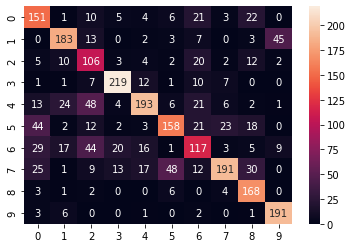

In [ ]:
sns.heatmap(conf, annot=True, fmt="d")

In [ ]:
file_path='/content/drive/My Drive/Colab Notebooks/Music Genre Classification/data'

In [ ]:
SAMPLE_RATE = 22050 # custom
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def save_mfcc_for_test_file(example, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
  samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  signal, sample_rate = librosa.load(example, sr=SAMPLE_RATE)
  data = {
        "mfcc": []
    }
  for d in range(num_segments):
    start = samples_per_segment * d
    finish = start + samples_per_segment
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T # transpose
    # store only mfcc for segment if it has expected number of vectors
    if len(mfcc) == num_mfcc_vectors_per_segment:
      data["mfcc"].append(mfcc.tolist())
  return data

In [ ]:
example_file = file_path + "/genres/classical/classical.00010.wav"

In [ ]:
my_X = np.array(save_mfcc_for_test_file(example_file)["mfcc"])

In [ ]:
my_preds = model_cnn.predict(my_X)

In [ ]:
my_preds_label = np.argmax(my_preds,axis=1)

In [ ]:
my_preds_label

array([9, 9, 9, 9, 9, 9, 9, 1, 9, 9])

In [ ]:
# From mapping, we can see 9 is indeed classical
# 0-‘disco’, 1-‘jazz’, 2-‘country’, 3-‘metal’, 4-‘blues’, 5-‘reggae’, 6-‘rock’, 7-‘hiphop’, 8-‘pop’, 9-‘classical’
mapping[1:11]

array(['disco', 'jazz', 'country', 'metal', 'blues', 'reggae', 'rock',
       'hiphop', 'pop', 'classical'], dtype='<U9')

In [ ]:
example_file2 = file_path + "/genres/reggae/reggae.00010.wav"

In [ ]:
my_X2 = np.array(save_mfcc_for_test_file(example_file2)["mfcc"])

In [ ]:
my_preds2 = model_cnn.predict(my_X2)

In [ ]:
my_preds_label2 = np.argmax(my_preds2,axis=1)

In [ ]:
my_preds_label2

array([5, 6, 5, 4, 6, 5, 5, 5, 5, 6])

In [ ]:
import IPython.display as ipd
x, sr = librosa.load(example_file2, sr=SAMPLE_RATE, mono=True)
start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

In [ ]:
example_file3 = file_path + "/genres/rock/rock.00010.wav"

In [ ]:
my_X3 = np.array(save_mfcc_for_test_file(example_file3)["mfcc"])

In [ ]:
my_preds3 = model_cnn.predict(my_X3)
my_preds_label3 = np.argmax(my_preds3,axis=1)
my_preds_label3

array([6, 2, 6, 7, 6, 0, 6, 0, 6, 0])

In [ ]:
x, sr = librosa.load(example_file3, sr=SAMPLE_RATE, mono=True)
start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)